In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# 读取训练集和测试集CSV文件
train_data = pd.read_csv("data\\train.csv")
test_data = pd.read_csv("data\\test.csv")
m, n = train_data.shape

# 选择训练集特征和标签列
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

# 选择测试集特征列
X_test = test_data.iloc[:, 1:].values
X_train, X_test = X_train / 255, X_test / 255
y_dev = test_data.iloc[:, 0].values #测试集对应的真实标签

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (42000, 784)
y_train shape: (42000,)
X_test shape: (28000, 784)


In [3]:


def projection_simplex(v, z=1):
    """
    投影到单纯形上的算法：
    """
    # v的维度，即特征数量
    n_features = v.shape[0]
    
    # 将v的元素从大到小排序
    u = np.sort(v)[::-1]
    
    # 计算从大到小累加的u的值与z的差值
    cssv = np.cumsum(u) - z
    
    # 创建一个从1到n_features的数组
    ind = np.arange(n_features) + 1
    
    # 找出满足条件u - cssv / ind > 0的索引
    cond = u - cssv / ind > 0
    
    # 找到最后一个满足条件的索引
    rho = ind[cond][-1]
    
    # 计算theta，即最后一个满足条件的cssv值除以对应的ind值
    theta = cssv[cond][-1] / float(rho)
    
    # 计算投影结果，即v - theta的元素若为负则置为0，保证w的每个分量都非负
    w = np.maximum(v - theta, 0)
    
    # 返回投影向量
    return w


In [4]:
class MulticlassSVM(BaseEstimator, ClassifierMixin):
    # 定义一个多类SVM类，它继承自BaseEstimator和ClassifierMixin。

    def __init__(self, C=1, max_iter=50, tol=0.05,
                 random_state=None, verbose=0):
        # 初始化方法，设置SVM的超参数。
        self.C = C  # 惩罚参数
        self.max_iter = max_iter  # 最大迭代次数
        self.tol = tol  # 容忍度，用于判断是否收敛
        self.random_state = random_state  # 随机种子，用于结果复现
        self.verbose = verbose  # 是否输出日志信息

    def _partial_gradient(self, X, y, i):
        # 计算第i个样本的偏导数。
        g = np.dot(X[i], self.coef_.T) + 1
        g[y[i]] -= 1
        return g

    def _violation(self, g, y, i):
        # 计算第i个样本的违反最优性程度。
        smallest = np.inf
        for k in range(g.shape[0]):
            if k == y[i] and self.dual_coef_[k, i] >= self.C:
                continue
            elif k != y[i] and self.dual_coef_[k, i] >= 0:
                continue

            smallest = min(smallest, g[k])

        return g.max() - smallest

    def _solve_subproblem(self, g, y, norms, i):
        # 为第i个样本解决子问题。
        Ci = np.zeros(g.shape[0])
        Ci[y[i]] = self.C
        beta_hat = norms[i] * (Ci - self.dual_coef_[:, i]) + g / norms[i]
        z = self.C * norms[i]

        # 计算在单纯形上的投影。
        beta = projection_simplex(beta_hat, z)

        return Ci - self.dual_coef_[:, i] - beta / norms[i]

    def fit(self, X, y):
        # 训练SVM模型。
        n_samples, n_features = X.shape

        self.vratios = []

        # 标准化标签。
        self._label_encoder = LabelEncoder()
        y = self._label_encoder.fit_transform(y)

        # 初始化原始和对偶系数。
        n_classes = len(self._label_encoder.classes_)
        self.dual_coef_ = np.zeros((n_classes, n_samples), dtype=np.float64)
        self.coef_ = np.zeros((n_classes, n_features))

        # 预计算范数。
        norms = np.sqrt(np.sum(X ** 2, axis=1))

        # 打乱样本索引。
        rs = check_random_state(self.random_state)
        ind = np.arange(n_samples)
        rs.shuffle(ind)

        violation_init = None
        for it in range(self.max_iter):
            violation_sum = 0

            for ii in range(n_samples):
                i = ind[ii]

                # 可以安全忽略所有为零的样本。
                if norms[i] == 0:
                    continue

                g = self._partial_gradient(X, y, i)
                v = self._violation(g, y, i)
                violation_sum += v

                if v < 1e-12:
                    continue

                # 解决第i个样本的子问题。
                delta = self._solve_subproblem(g, y, norms, i)

                # 更新原始和对偶系数。
                self.coef_ += (delta * X[i][:, np.newaxis]).T
                self.dual_coef_[:, i] += delta

            if it == 0:
                violation_init = violation_sum

            vratio = violation_sum / violation_init
            
            self.vratios.append(vratio)

            if self.verbose >= 1:
                print("迭代次数", it + 1, "违反最优性程度", vratio)

            if vratio < self.tol:
                if self.verbose >= 1:
                    print("Converged")
                break

        return self
    def _plot_history(self):
        plt.figure(figsize=(12, 4))
        plt.plot(range(self.max_iter), self.vratios)
        plt.title('violation')
        plt.xlabel('Iteration')
        plt.ylabel('violation')

    def predict(self, X):
        # 使用训练好的模型进行预测。
        decision = np.dot(X, self.coef_.T)
        pred = decision.argmax(axis=1)
        return self._label_encoder.inverse_transform(pred)


迭代次数 1 违反最优性程度 1.0
迭代次数 2 违反最优性程度 1.0311055511931222
迭代次数 3 违反最优性程度 0.9143846834037691
迭代次数 4 违反最优性程度 0.853411672576593
迭代次数 5 违反最优性程度 0.7929496418169559
迭代次数 6 违反最优性程度 0.7275584227083871
迭代次数 7 违反最优性程度 0.6586333655853283
迭代次数 8 违反最优性程度 0.5916385735635847
迭代次数 9 违反最优性程度 0.5378909574996005
迭代次数 10 违反最优性程度 0.48647455278165097
迭代次数 11 违反最优性程度 0.44509601702681806
迭代次数 12 违反最优性程度 0.40426614600941485
迭代次数 13 违反最优性程度 0.372652444438025
迭代次数 14 违反最优性程度 0.34374525751975377
迭代次数 15 违反最优性程度 0.32013691717221276
迭代次数 16 违反最优性程度 0.2996447795556899
迭代次数 17 违反最优性程度 0.27656146944161253
迭代次数 18 违反最优性程度 0.2572516695749934
迭代次数 19 违反最优性程度 0.24208378925805152
迭代次数 20 违反最优性程度 0.2284051438317418
迭代次数 21 违反最优性程度 0.2138831084960036
迭代次数 22 违反最优性程度 0.20213608888282858
迭代次数 23 违反最优性程度 0.1915171762342296
迭代次数 24 违反最优性程度 0.18132860212841576
迭代次数 25 违反最优性程度 0.17143561474284782
迭代次数 26 违反最优性程度 0.16154572200164527
迭代次数 27 违反最优性程度 0.15418026909670834
迭代次数 28 违反最优性程度 0.14853399140173004
迭代次数 29 违反最优性程度 0.142211338289130

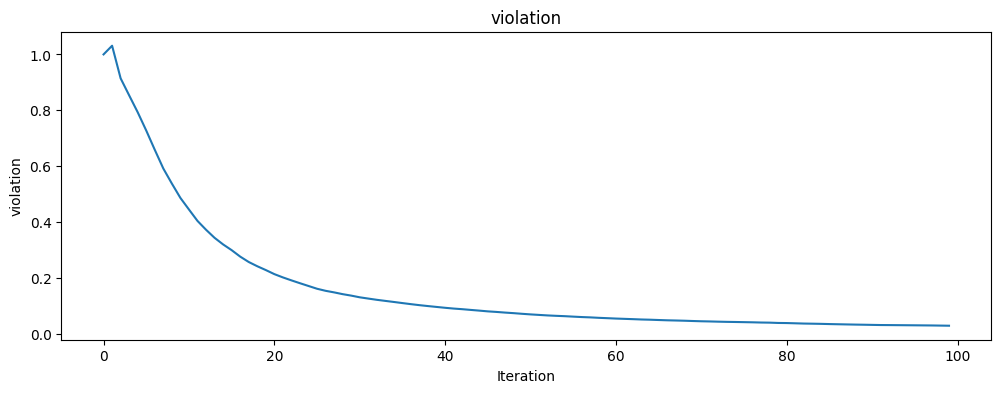

In [5]:
clf = MulticlassSVM(C=0.1, tol=0.01, max_iter=100, random_state=0, verbose=1)
clf.fit(X_train, y_train)
clf._plot_history()
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_dev))

In [6]:
sample_submission = pd.read_csv("data\\sample_submission.csv")
sample_submission['Label'] = y_pred
sample_submission.to_csv("svm_submission.csv", index=False)